In [17]:
import torch.nn as nn
import torch
from torchview import draw_graph

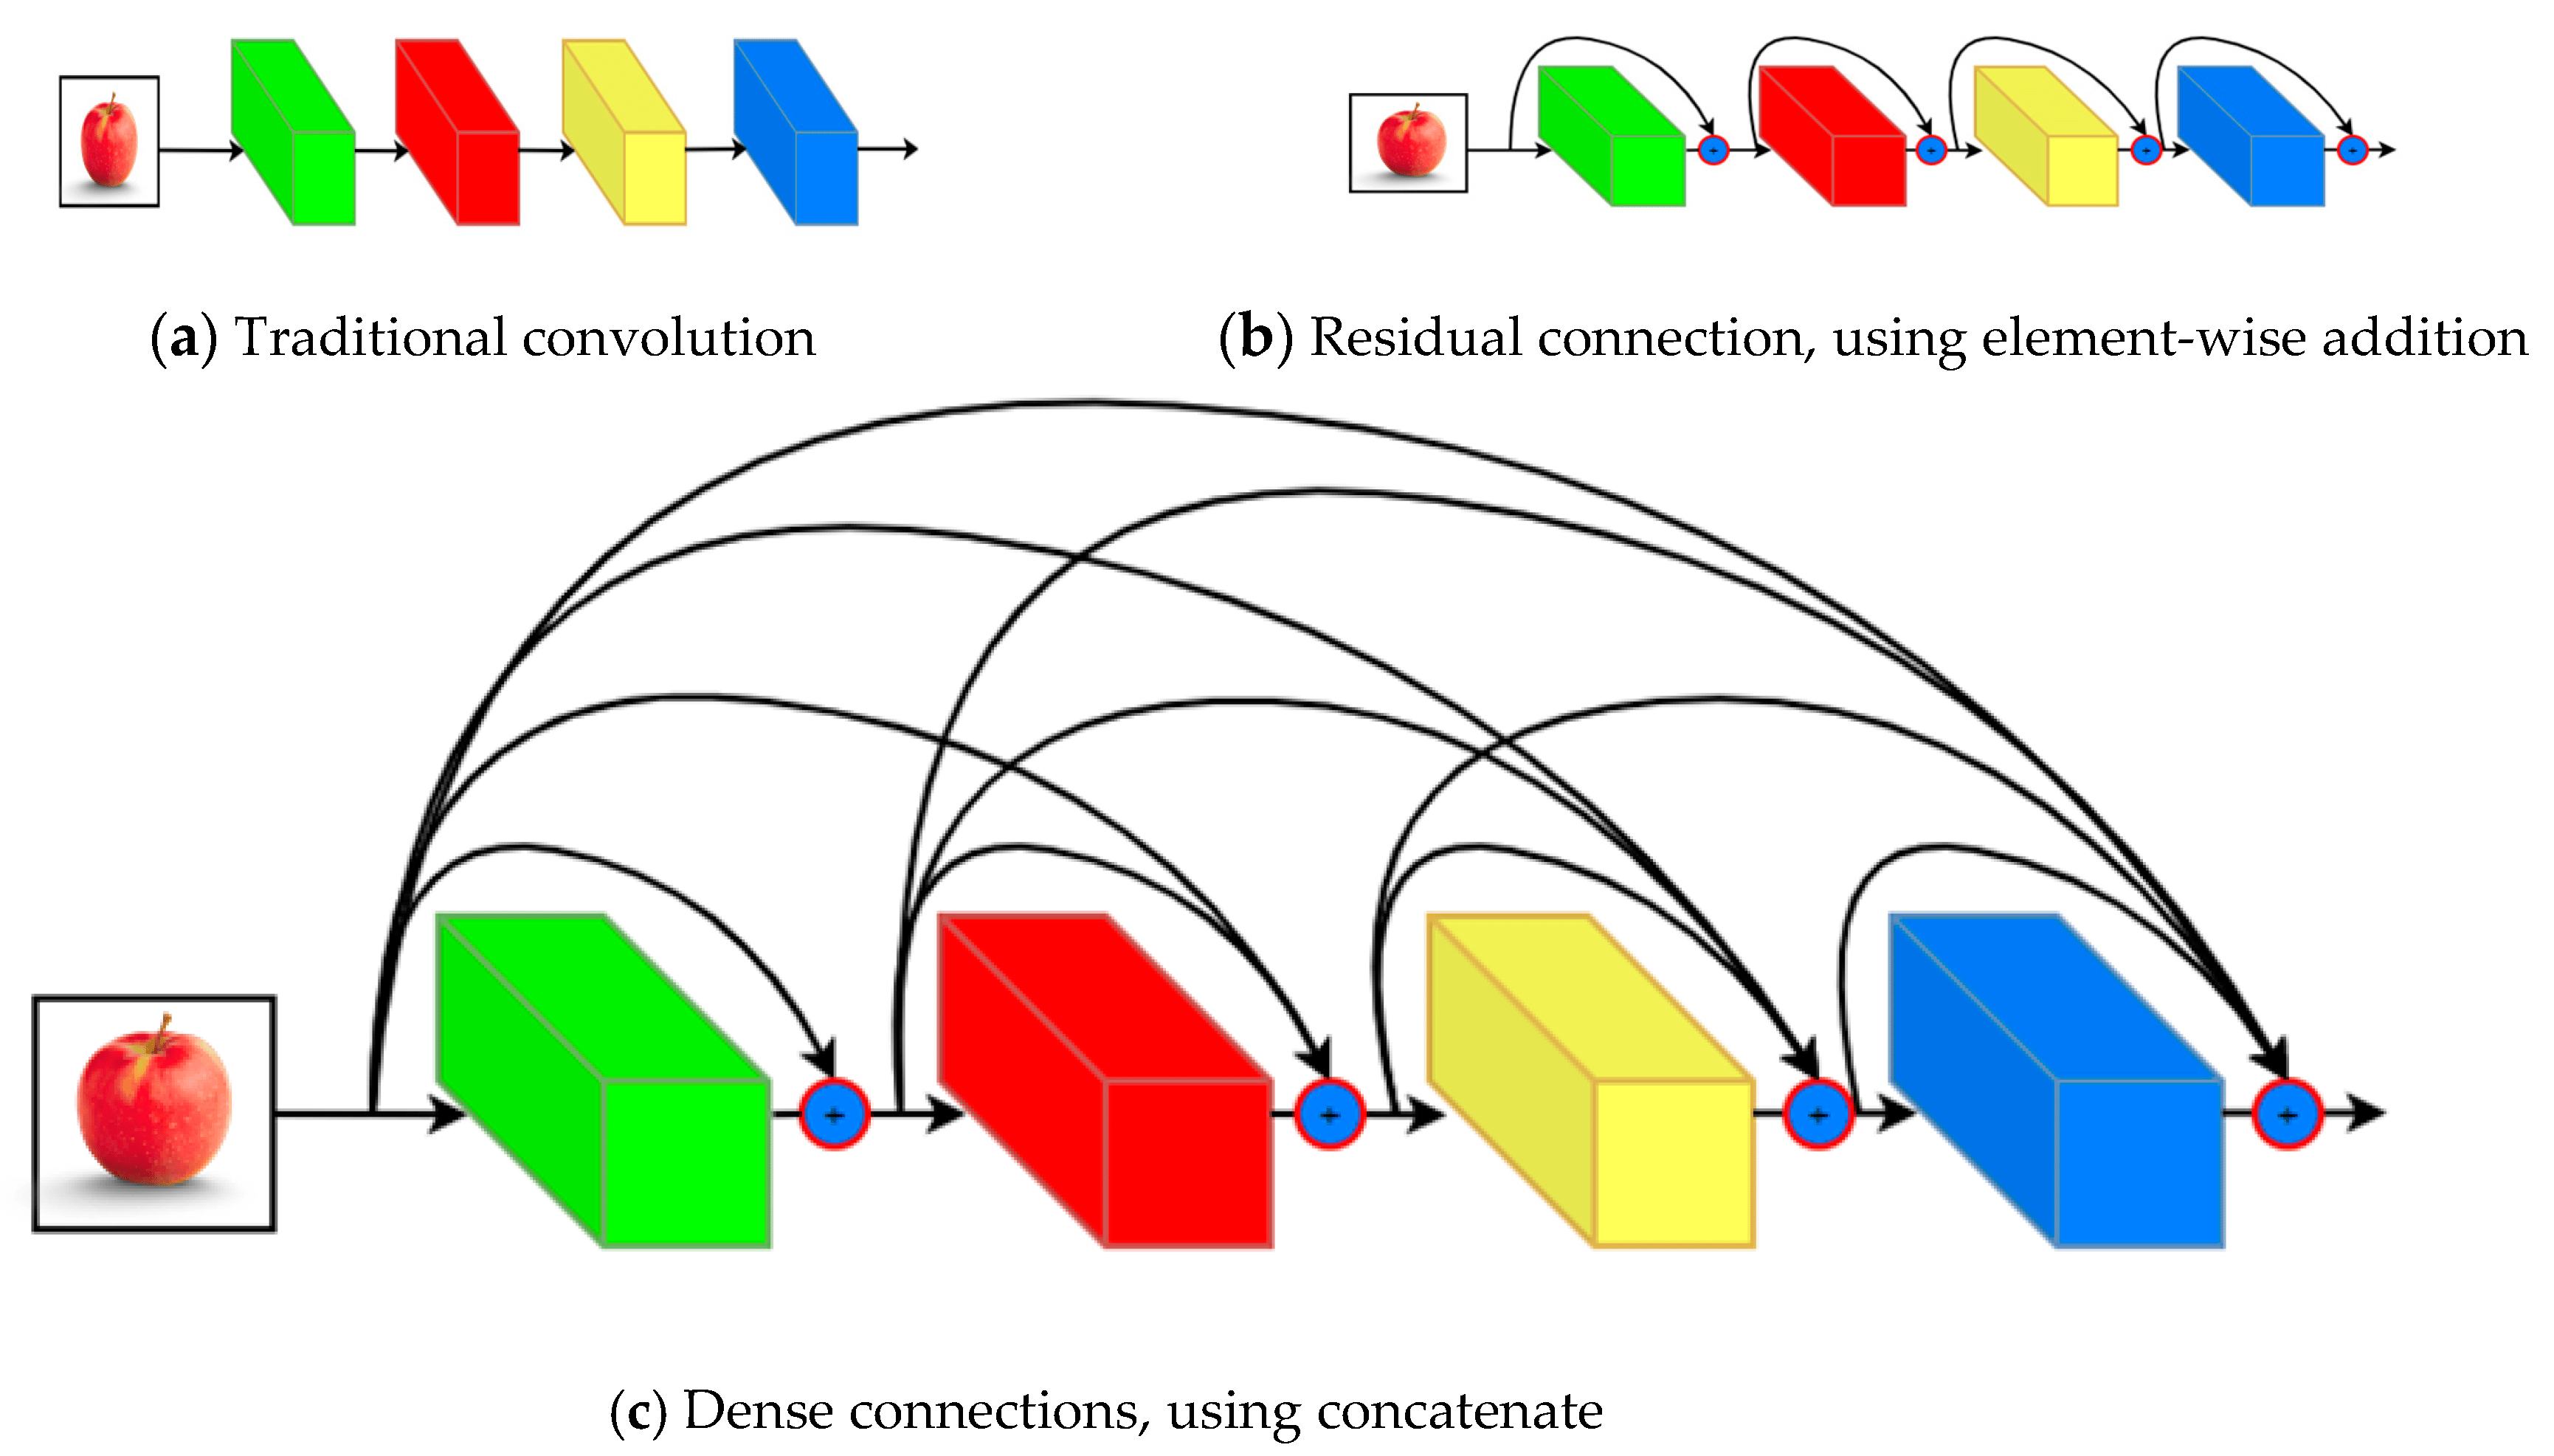

In [18]:
class DenseBlock(nn.Module):
    def __init__(self, input_num_planes, rate_inc):
        super(DenseBlock, self).__init__()
        self.batch_norm1 = nn.BatchNorm2d(input_num_planes)
        self.conv_layer1 = nn.Conv2d(in_channels=input_num_planes, out_channels=4*rate_inc, kernel_size=1, bias=False)
        self.batch_norm2 = nn.BatchNorm2d(4*rate_inc)
        self.conv_layer2 = nn.Conv2d(in_channels=4*rate_inc, out_channels=rate_inc, kernel_size=3, padding=1, bias=False)
    def forward(self, inp):
        op = self.conv_layer1(F.relu(self.batch_norm1(inp)))
        op = self.conv_layer2(F.relu(self.batch_norm2(op)))
        op = torch.cat([op,inp], 1)
        return op

class TransBlock(nn.Module):
    def __init__(self, input_num_planes, output_num_planes):
        super(TransBlock, self).__init__()
        self.batch_norm = nn.BatchNorm2d(input_num_planes)
        self.conv_layer = nn.Conv2d(in_channels=input_num_planes, out_channels=output_num_planes, kernel_size=1, bias=False)
    def forward(self, inp):
        op = self.conv_layer(F.relu(self.batch_norm(inp)))
        op = F.avg_pool2d(op, 2)
        return op

#### Full DenseNet Code

In [19]:
model_parameters={}
model_parameters['densenet121'] = [6,12,24,16]
model_parameters['densenet169'] = [6,12,32,32]
model_parameters['densenet201'] = [6,12,48,32]
model_parameters['densenet264'] = [6,12,64,48]

# growth rate
k = 32
compression_factor = 0.5

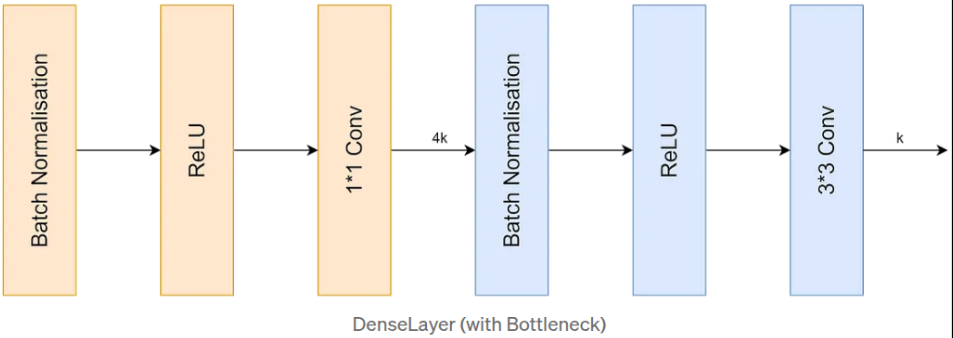

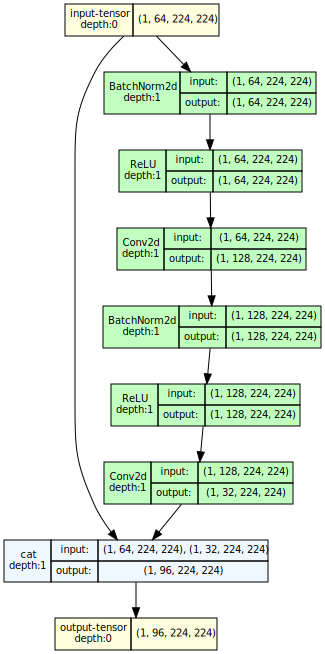

In [20]:
class DenseLayer(nn.Module):

    def __init__(self,in_channels):
        """
        First 1x1 convolution generating 4*k number of channels irrespective of the total number of input channels.
        First 3x3 convolution generating k number of channels from the 4*k number of input channels.

        Args:
        in_channels (int) : # input channels to the Dense Layer

        """
        super(DenseLayer,self).__init__()

        self.BN1 = nn.BatchNorm2d(num_features = in_channels)
        self.conv1 = nn.Conv2d( in_channels=in_channels , out_channels=4*k , kernel_size=1 , stride=1 , padding=0 , bias = False )

        self.BN2 = nn.BatchNorm2d(num_features = 4*k)
        self.conv2 = nn.Conv2d( in_channels=4*k , out_channels=k , kernel_size=3 , stride=1 , padding=1 , bias = False )

        self.relu = nn.ReLU()

    def forward(self,x):
        """
        Bottleneck DenseLayer with following operations
        (i) batchnorm -> relu -> 1x1 conv
        (ii) batchnorm -> relu -> 3x3 conv
        
        Concatenation of input and output tensor which is the main idea of DenseNet. 

        Args:
            x (tensor) : input tensor to be passed through the dense layer
        
        Attributes:
            x (tensor) : output tensor 

        """

        xin = x

        # BN -> relu -> conv(1x1)
        x = self.BN1(x)
        x = self.relu(x)
        x = self.conv1(x)

        # BN -> relu -> conv(3x3)
        x = self.BN2(x)
        x = self.relu(x)
        x = self.conv2(x)

        x = torch.cat([xin,x],1)

        return x


def test_DenseLayer():
    x = torch.randn(1,64,224,224)
    model = DenseLayer(64)
    # print(model(x).shape)
    # print(model)
    # del model
    return model


model = test_DenseLayer()

architecture = 'denselayer'
model_graph = draw_graph(model, input_size=(1,64,224,224), graph_dir ='TB' , roll=True, expand_nested=True, graph_name=f'self_{architecture}',save_graph=True,filename=f'self_{architecture}')
model_graph.visual_graph


In [21]:
# output
'''
Model Output Size :  torch.Size([1, 96, 224, 224])
DenseLayer(
  (BN1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1): Conv2d(64, 48, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (BN2): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(48, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (relu): ReLU()
)
'''

'\nModel Output Size :  torch.Size([1, 96, 224, 224])\nDenseLayer(\n  (BN1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)\n  (conv1): Conv2d(64, 48, kernel_size=(1, 1), stride=(1, 1), bias=False)\n  (BN2): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)\n  (conv2): Conv2d(48, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)\n  (relu): ReLU()\n)\n'

xin shape torch.Size([1, 3, 224, 224])
xout shape torch.Size([1, 35, 224, 224])
xout shape torch.Size([1, 67, 224, 224])
xout shape torch.Size([1, 99, 224, 224])
Denseblock Output shape :  torch.Size([1, 99, 224, 224])
Model  DenseBlock(
  (deep_nn): ModuleList(
    (0): DenseLayer(
      (BN1): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(3, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (BN2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (relu): ReLU()
    )
    (1): DenseLayer(
      (BN1): BatchNorm2d(35, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(35, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (BN2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 32, kernel_size=(3,

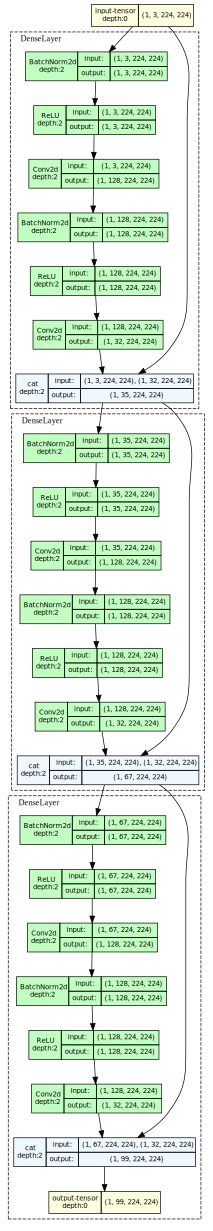

In [22]:
###  Define DenseBlock
class DenseBlock(nn.Module):
    def __init__(self,layer_num,in_channels):
        """
        Looping through total number of layers in the denseblock. 
        Adding k number of channels in each loop as each layer generates tensor with k channels.
        
        Args:
            layer_num (int) : total number of dense layers in the dense block
            in_channels (int) : input number of channels 
        """

        super(DenseBlock,self).__init__()
        self.layer_num = layer_num
        self.deep_nn = nn.ModuleList()

        for num in range(self.layer_num):
            self.deep_nn.add_module(f"DenseLayer_{num}",DenseLayer(in_channels+k*num))


    def forward(self,x):
        """
        Args:
            x (tensor) : input tensor to be passed through the dense block
        
        Attributes:
            x (tensor) : output tensor 
        """
        xin = x
        print('xin shape',xin.shape)

        for layer in self.deep_nn:
            x = layer(x)
            print('xout shape',x.shape)
        return x




def test_DenseBlock():
    x = torch.randn(1,3,224,224)
    model = DenseBlock(3,3)
    print('Denseblock Output shape : ',model(x).shape)
    print('Model ',model)
    # del model
    return model


model = test_DenseBlock()

architecture = 'denseblock'
model_graph = draw_graph(model, input_size=(1,3,224,224), graph_dir ='TB' , roll=True, expand_nested=True, graph_name=f'self_{architecture}',save_graph=True,filename=f'self_{architecture}')
model_graph.visual_graph


In [23]:
# output
"""
xin shape torch.Size([1, 3, 224, 224])
xout shape torch.Size([1, 15, 224, 224])
xout shape torch.Size([1, 27, 224, 224])
xout shape torch.Size([1, 39, 224, 224])
torch.Size([1, 39, 224, 224])
DenseBlock(
  (deep_nn): ModuleList(
    (0): DenseLayer(
      (BN1): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(3, 48, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (BN2): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(48, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (relu): ReLU()
    )
    (1): DenseLayer(
      (BN1): BatchNorm2d(15, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(15, 48, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (BN2): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(48, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (relu): ReLU()
    )
    (2): DenseLayer(
      (BN1): BatchNorm2d(27, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(27, 48, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (BN2): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(48, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (relu): ReLU()
    )
  )
)
"""

'\nxin shape torch.Size([1, 3, 224, 224])\nxout shape torch.Size([1, 15, 224, 224])\nxout shape torch.Size([1, 27, 224, 224])\nxout shape torch.Size([1, 39, 224, 224])\ntorch.Size([1, 39, 224, 224])\nDenseBlock(\n  (deep_nn): ModuleList(\n    (0): DenseLayer(\n      (BN1): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)\n      (conv1): Conv2d(3, 48, kernel_size=(1, 1), stride=(1, 1), bias=False)\n      (BN2): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)\n      (conv2): Conv2d(48, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)\n      (relu): ReLU()\n    )\n    (1): DenseLayer(\n      (BN1): BatchNorm2d(15, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)\n      (conv1): Conv2d(15, 48, kernel_size=(1, 1), stride=(1, 1), bias=False)\n      (BN2): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)\n      (conv2): Conv2d(48, 12, kernel_size=(3, 3), stride=(1, 1),

Transition Layer Output shape :  torch.Size([1, 32, 112, 112])
Model :  TransitionLayer(
  (BN): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (avgpool): AvgPool2d(kernel_size=2, stride=2, padding=0)
)


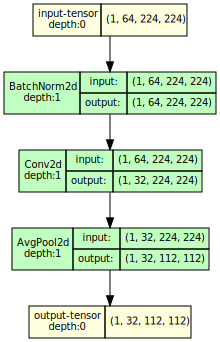

In [24]:
### Define Transition Layer
class TransitionLayer(nn.Module):
    def __init__(self,in_channels,compression_factor):
        """
        1x1 conv used to change output channels using the compression_factor (default = 0.5).
        avgpool used to downsample the feature map resolution 
        
        Args:
            compression_factor (float) : output_channels/input_channels
            in_channels (int) : input number of channels 
        """

        super(TransitionLayer,self).__init__()
        self.BN = nn.BatchNorm2d(in_channels)
        self.conv1 = nn.Conv2d(in_channels = in_channels , out_channels = int(in_channels*compression_factor) ,kernel_size = 1 ,stride = 1 ,padding = 0, bias=False )
        self.avgpool = nn.AvgPool2d(kernel_size = 2, stride = 2)

    def forward(self,x):
        """
        Args:
            x (tensor) : input tensor to be passed through the dense block
        
        Attributes:
            x (tensor) : output tensor
        """
        x = self.BN(x)
        x = self.conv1(x)
        x = self.avgpool(x)
        return x



def test_TransitionLayer():
    x = torch.randn(1,64,224,224)
    model = TransitionLayer(64,compression_factor)
    print('Transition Layer Output shape : ',model(x).shape)
    print('Model : ',model)
    return model


model = test_TransitionLayer()
architecture = 'transition'
model_graph = draw_graph(model, input_size=(1,64,224,224), graph_dir ='TB' , roll=True, expand_nested=True, graph_name=f'self_{architecture}',save_graph=True,filename=f'self_{architecture}')
model_graph.visual_graph


In [25]:

# output
"""
Transition Layer Output shape :  torch.Size([1, 32, 112, 112])
Model :  TransitionLayer(
  (BN): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
  (avgpool): AvgPool2d(kernel_size=2, stride=2, padding=0)
)
"""

'\nTransition Layer Output shape :  torch.Size([1, 32, 112, 112])\nModel :  TransitionLayer(\n  (BN): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)\n  (conv1): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))\n  (avgpool): AvgPool2d(kernel_size=2, stride=2, padding=0)\n)\n'

In [ ]:
### Define DenseNet
class DenseNet(nn.Module):
    def __init__(self,densenet_variant,in_channels,num_classes=1000):
        
        """
        Creating an initial 7x7 convolution followed by 3 DenseBlock and 3 Transition layers. 
        Concluding this with 4th DenseBlock, 7x7 global average pool and FC layer
        for classification  
        Args:
            densenet_variant (list) : list containing the total number of layers in a dense block
            in_channels (int) : input number of channels
            num_classes (int) : Total nnumber of output classes 
        
        """

        super(DenseNet,self).__init__()

        # 7x7 conv with s=2 and maxpool
        self.conv1 = nn.Conv2d(in_channels=in_channels ,out_channels=64 ,kernel_size=7 ,stride=2 ,padding=3 ,bias = False)
        self.BN1 = nn.BatchNorm2d(num_features=64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)


        # adding 3 DenseBlocks and 3 Transition Layers 
        self.deep_nn = nn.ModuleList()
        dense_block_inchannels = 64

        for num in range(len(densenet_variant))[:-1]:

            self.deep_nn.add_module( f"DenseBlock_{num+1}" , DenseBlock( densenet_variant[num] , dense_block_inchannels ) )
            dense_block_inchannels  = int(dense_block_inchannels + k*densenet_variant[num])

            self.deep_nn.add_module( f"TransitionLayer_{num+1}" , TransitionLayer( dense_block_inchannels,compression_factor ) )
            dense_block_inchannels = int(dense_block_inchannels*compression_factor)

        # adding the 4th and final DenseBlock
        self.deep_nn.add_module( f"DenseBlock_{num+2}" , DenseBlock( densenet_variant[-1] , dense_block_inchannels ) )
        dense_block_inchannels  = int(dense_block_inchannels + k*densenet_variant[-1])

        self.BN2 = nn.BatchNorm2d(num_features=dense_block_inchannels)

        # Average Pool
        self.average_pool = nn.AdaptiveAvgPool2d(1)
        
        # fully connected layer
        self.fc1 = nn.Linear(dense_block_inchannels, num_classes)


    def forward(self,x):
        """
        deep_nn is the module_list container which has all the dense blocks and transition blocks
        """
        x = self.relu(self.BN1(self.conv1(x)))
        x = self.maxpool(x)
        
        for layer in self.deep_nn:
            x = layer(x)
            
        x = self.relu(self.BN2(x))
        x = self.average_pool(x)

        x = torch.flatten(x, start_dim=1)
        x = self.fc1(x)

        # print(x.shape)
        return x

x = torch.randn(1,3,224,224)
model = DenseNet(model_parameters['densenet121'],3)

architecture = 'denseNet'
model_graph = draw_graph(model, input_size=(1,3,224,224), graph_dir ='TB' , roll=False, expand_nested=True, show_shapes=True, graph_name=f'self_{architecture}',save_graph=True,filename=f'self_{architecture}')
# model_graph.visual_graph

xin shape torch.Size([1, 64, 56, 56])
xout shape torch.Size([1, 96, 56, 56])
xout shape torch.Size([1, 128, 56, 56])
xout shape torch.Size([1, 160, 56, 56])
xout shape torch.Size([1, 192, 56, 56])
xout shape torch.Size([1, 224, 56, 56])
xout shape torch.Size([1, 256, 56, 56])
xin shape torch.Size([1, 128, 28, 28])
xout shape torch.Size([1, 160, 28, 28])
xout shape torch.Size([1, 192, 28, 28])
xout shape torch.Size([1, 224, 28, 28])
xout shape torch.Size([1, 256, 28, 28])
xout shape torch.Size([1, 288, 28, 28])
xout shape torch.Size([1, 320, 28, 28])
xout shape torch.Size([1, 352, 28, 28])
xout shape torch.Size([1, 384, 28, 28])
xout shape torch.Size([1, 416, 28, 28])
xout shape torch.Size([1, 448, 28, 28])
xout shape torch.Size([1, 480, 28, 28])
xout shape torch.Size([1, 512, 28, 28])
xin shape torch.Size([1, 256, 14, 14])
xout shape torch.Size([1, 288, 14, 14])
xout shape torch.Size([1, 320, 14, 14])
xout shape torch.Size([1, 352, 14, 14])
xout shape torch.Size([1, 384, 14, 14])
xout 

In [30]:
from torchsummary import summary
summary(model, (3, 224, 224))


xin shape torch.Size([2, 64, 56, 56])
xout shape torch.Size([2, 96, 56, 56])
xout shape torch.Size([2, 128, 56, 56])
xout shape torch.Size([2, 160, 56, 56])
xout shape torch.Size([2, 192, 56, 56])
xout shape torch.Size([2, 224, 56, 56])
xout shape torch.Size([2, 256, 56, 56])
xin shape torch.Size([2, 128, 28, 28])
xout shape torch.Size([2, 160, 28, 28])
xout shape torch.Size([2, 192, 28, 28])
xout shape torch.Size([2, 224, 28, 28])
xout shape torch.Size([2, 256, 28, 28])
xout shape torch.Size([2, 288, 28, 28])
xout shape torch.Size([2, 320, 28, 28])
xout shape torch.Size([2, 352, 28, 28])
xout shape torch.Size([2, 384, 28, 28])
xout shape torch.Size([2, 416, 28, 28])
xout shape torch.Size([2, 448, 28, 28])
xout shape torch.Size([2, 480, 28, 28])
xout shape torch.Size([2, 512, 28, 28])
xin shape torch.Size([2, 256, 14, 14])
xout shape torch.Size([2, 288, 14, 14])
xout shape torch.Size([2, 320, 14, 14])
xout shape torch.Size([2, 352, 14, 14])
xout shape torch.Size([2, 384, 14, 14])
xout 

In [31]:
import torchvision
from torchvision.models import densenet121,DenseNet121_Weights
torchvision_model = densenet121(weights=DenseNet121_Weights.IMAGENET1K_V1)

architecture = 'torchvision_model'
model_graph = draw_graph(torchvision_model, input_size=(1,3,224,224), graph_dir ='TB' , roll=False, expand_nested=True, show_shapes=True, graph_name=f'self_{architecture}',save_graph=True,filename=f'self_{architecture}')

# summary(torchvision_model, (3, 224, 224))
total_params = sum(p.numel() for p in torchvision_model.parameters())
print(total_params)


Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /home/mb600l/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:03<00:00, 10.6MB/s]


7978856


In [32]:
# DenseNet from scratch
count = 0
for n, param in model.named_parameters():
    # print('########################',n,param.requires_grad,param.data.shape,param.reshape(-1).shape)
    print('########################',count,param.data.shape,param.reshape(-1).shape)
    count += 1
    # break


# DenseNet from torchvision
count = 0
for n, param in model.named_parameters():
    # print('########################',n,param.requires_grad,param.data.shape,param.reshape(-1).shape)
    print('########################',count,param.data.shape,param.reshape(-1).shape)
    count += 1
    # break

######################## 0 torch.Size([64, 3, 7, 7]) torch.Size([9408])
######################## 1 torch.Size([64]) torch.Size([64])
######################## 2 torch.Size([64]) torch.Size([64])
######################## 3 torch.Size([64]) torch.Size([64])
######################## 4 torch.Size([64]) torch.Size([64])
######################## 5 torch.Size([128, 64, 1, 1]) torch.Size([8192])
######################## 6 torch.Size([128]) torch.Size([128])
######################## 7 torch.Size([128]) torch.Size([128])
######################## 8 torch.Size([32, 128, 3, 3]) torch.Size([36864])
######################## 9 torch.Size([96]) torch.Size([96])
######################## 10 torch.Size([96]) torch.Size([96])
######################## 11 torch.Size([128, 96, 1, 1]) torch.Size([12288])
######################## 12 torch.Size([128]) torch.Size([128])
######################## 13 torch.Size([128]) torch.Size([128])
######################## 14 torch.Size([32, 128, 3, 3]) torch.Size([36864])
######

https://arxiv.org/pdf/1608.06993

https://medium.com/@karuneshu21/densenet-paper-walkthrough-764481fced3a

https://medium.com/@karuneshu21/implement-densenet-in-pytorch-46374ef91900
